In [28]:
import fit
from espace import build_espace
from gf_lanczos import build_gf_lanczos
from lookup import get_sector_index

In [2]:
delta_true = lambda z: -0.1j

In [42]:
delta = fit.fit_hybrid(delta_true, 15)

         Current function value: 0.000150
         Iterations: 1973
         Function evaluations: 71188
         Gradient evaluations: 2296


In [44]:
n = delta.a.size + 1
H = np.zeros((n,n))
V = np.zeros((n,n))

H[0,1:] = H[1:,0] = delta.b
for i in range(1,n):
    H[i,i] = delta.a[i-1]

U = 0.
V[0,0] = U

nup = 8
ndw = 8
neig_sector = np.zeros((n+1)*(n+1),int)
neig_sector[get_sector_index(nup,ndw,n)] = 1
# neig_sector[get_sector_index(ndw,nup,n)] = 1

eigen_space, egs = build_espace(H, V, neig_sector)
gf = build_gf_lanczos(H, V, eigen_space, 0.)

KeyboardInterrupt: 

In [ ]:
energies = np.arange(-2,2,1e-2)
eta = 0.25

In [ ]:
dos = -1/np.pi*gf(energies, eta).imag

In [ ]:
plt.plot(dos)

In [37]:
from shared import params
params['hfmode'] = False

In [38]:
U = 1
V[0,0] = U
H[0,0] = -U/2

In [39]:
eigen_space, egs = build_espace(H, V, neig_sector)
gf = build_gf_lanczos(H, V, eigen_space, 0.)

In [40]:
dos = -1/np.pi*gf(energies, eta).imag

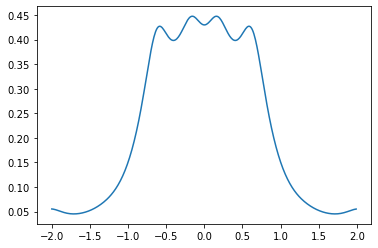

In [41]:
plt.plot(energies, dos)